In [10]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

In [11]:
opti=asb.Opti(cache_filename="soln1.json")


### Constants
# World
g = 9.81  # [m/s^2]
e = 0.7  # Oswald efficiency factor standard for A320

# Structural
mass = 63000  # [kg]
weight = mass * g
weight_fuselage = 20000 * g  # [N] assumed fuselage weight
W_W_coeff1 = 7e-6  # Wing Weight Coefficient 1 [1/m]
W_W_coeff2 = 45.24  # Wing Weight Coefficient 2 [Pa]
ultimate_load_factor = 3.8  # ultimate load factor [-]
airfoil_thickness_fraction = 0.12  # Approx. for SC(2)-0412

# Propulsion
engine_thrust = 105000  # [N]
engine_tsfc = 0.0035  # [kg/m]

# Operating conditions
cruise_alt = 11000  # [m]
service_ceil = 13100  # [m]
atm = asb.atmosphere.Atmosphere(cruise_alt)
cruise_mach = 0.8  # [mach]
cruise_speed = atm.speed_of_sound() * cruise_mach


### Variables
# Main wing
wing_airfoil = asb.Airfoil("sc20412")
span = opti.variable(init_guess=45, lower_bound=35, upper_bound=50, scale=5)
chord_root = opti.variable(init_guess=3, lower_bound=1, upper_bound=15)
chord_tip = opti.variable(init_guess=1, lower_bound=.5, upper_bound=2)

# Truss wing
truss_span = span / 5
truss_chord_root = 1
truss_chord_tip = 0.5

# Stabs
stab_airfoil = asb.Airfoil("naca0012")
# aoa = opti.variable(init_guess=2, lower_bound=0, upper_bound=10, scale=1)


### Geoemtries
# Main wing
main_wing = asb.Wing(
    name="Main Wing",
    symmetric=True,  # Should this wing be mirrored across the XZ plane?
    xsecs=[  # The wing's cross ("X") sections
        asb.WingXSec(  # Root
            xyz_le=[
                0,
                0,
                1.5,
            ],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
            chord=chord_root,
            # twist=aoa,  # degrees
            airfoil=wing_airfoil  # Airfoils are blended between a given XSec and the next one.
        ),
        asb.WingXSec(  # Tip
            xyz_le=[
                np.sind(20) * (span/2),
                span / 2,
                1.5,
            ],
            chord=chord_tip,  # Tip chord is 20% of root chord
            # twist=aoa,
            airfoil=wing_airfoil
        ),
    ],
)
# Truss wing
truss_wing = asb.Wing(
    name="Wing Truss",
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[
                5, 
                0, 
                -1.5
            ],  # Truss connects to fuselage near root
            chord=truss_chord_root,
            airfoil=wing_airfoil,
        ),
        asb.WingXSec(
            xyz_le=[
                4,  # A bit inward from wing tip
                truss_span,
                -0.1 + 1.5 # Slight vertical offset to angle the truss
            ],
            chord=truss_chord_tip,
            airfoil=wing_airfoil,
        ),
    ]
)
# Ampenage
horiz_stab = asb.Wing(
    name="Horizontal stab",
    symmetric=True,
    xsecs=[
        asb.WingXSec(
            xyz_le=[21.5, 0, 1.0],  # Approx. location at rear fuselage
            chord=2.75,            # Larger root chord
            airfoil=stab_airfoil,  # Typically symmetric airfoil like NACA 0012
        ),
        asb.WingXSec(
            xyz_le=[24, 5.5, 0.9],  # Apply sweep and slight dihedral
            chord=1.0,                        # Smaller tip chord
            airfoil=stab_airfoil,
        ),
    ]
)
vert_stab = asb.Wing(
    name="Vertical stab",
    symmetric=False,
    xsecs=[
        asb.WingXSec(
            xyz_le=[21, 0, 1.0],  # Root at rear-top of fuselage
            chord=4.0,
            airfoil=stab_airfoil,  # Typically symmetric (e.g., NACA 0012)
        ),
        asb.WingXSec(
            xyz_le=[24.5, 0, 7],  # Add sweep, go upward
            chord=1.5,
            airfoil=stab_airfoil,
        ),
    ]
)
# Engines
left_engine = asb.Propulsor(
    name="Left Engine",
    xyz_c=[1.5, -7, -0.5],  # Approx. underwing, side-mounted
    radius=1,
    length=3.5
)
right_engine = asb.Propulsor(
    name="Right Engine",
    xyz_c=[1.5, 7, -0.5],  # Approx. underwing, side-mounted
    radius=1,
    length=3.5
)
# Fuselage
asb.horizontal
asb.Fuselage()
fuselage = asb.Fuselage(
    name="ACE-1 Fuselage",
    symmetric=True,
    xsecs=[
        asb.FuselageXSec(
            xyz_c=[-13.04-0.196, 0, -0.444],
            radius=0
        ),
        asb.FuselageXSec(
            xyz_c=[-13.04, 0, -0.444],
            radius=0.63842502/2
        ),
        asb.FuselageXSec(
            xyz_c=[-12.74, 0, -0.444],
            radius=1.04048993/2
        ),
        asb.FuselageXSec(
            xyz_c=[-11.727, 0, -0.44427933],
            radius=0.9648
        ),
        asb.FuselageXSec(
            xyz_c=[-10.610, 0, -0.21648632],
            radius=2.95801910/2
        ),
        asb.FuselageXSec(
            xyz_c=[-9.464, 0, -0.13295889],
            radius=1.719
        ),
        asb.FuselageXSec(
            xyz_c=[-7.411, 0, 0],
            radius=1.89
        ),
        asb.FuselageXSec(
            xyz_c=[-6.248, 0, 0],
            radius=1.88           # Constant diameter midsection
        ),
        asb.FuselageXSec(
            xyz_c=[11.25174427, 0, 0],
            radius=1.88           # Constant diameter midsection
        ),
        asb.FuselageXSec(
            xyz_c=[13.3389, 0, 0.0377],
            radius=1.858
        ),
        asb.FuselageXSec(
            xyz_c=[16.1137, 0, 0.20096818],
            radius=1.67718
        ),
        asb.FuselageXSec(
            xyz_c=[18.9266, 0, 0.48167075],
            radius=1.35949
        ),
        asb.FuselageXSec(
            xyz_c=[21.72, 0, 0.90215062],
            radius=0.9021
        ),
        asb.FuselageXSec(
            xyz_c=[26.0569, 0, 1.31256010],
            radius=0.471701
        ),
        asb.FuselageXSec(
            xyz_c=[26.25, 0, 1.31256010],
            radius=0
        )
    ]
)


# Wing weight model
weight_wing_structural = W_W_coeff1 * (
        ultimate_load_factor * main_wing.aspect_ratio() ** 1.5 *
        (weight_fuselage * weight * main_wing.area()) ** 0.5
) / airfoil_thickness_fraction
weight_wing_surface = W_W_coeff2 * main_wing.area()
weight_wing = weight_wing_surface + weight_wing_structural


airplane = asb.Airplane(
    name="ACE-1",
    xyz_ref=[0.25 * chord_root, 0, 0],  # CG location
    wings=[main_wing, truss_wing, horiz_stab, vert_stab],
    fuselages=[fuselage],
    propulsors=[left_engine, right_engine]
)


### Aerodynamics
vlm = asb.VortexLatticeMethod(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=cruise_speed,
        # alpha=5,
    )
)
abu = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=cruise_speed,
        # alpha=5,
    )
)
aero_vlm = vlm.run()
aero_abu = abu.run()

D_induced_vlm = aero_vlm["D"]
D_parasitic_abu = aero_abu["D_profile"]  # Already includes drag from all modeled components
D_total_hybrid = D_induced_vlm + D_parasitic_abu
L_vlm = aero_vlm["L"]  # More accurate lift


### Weight model
weight_wing_structural = W_W_coeff1 * (
        ultimate_load_factor * main_wing.aspect_ratio() ** 1.5 *
        (weight_fuselage * weight * main_wing.area()) ** 0.5
) / airfoil_thickness_fraction
weight_wing_surface = W_W_coeff2 * main_wing.area()
weight_wing = weight_wing_surface + weight_wing_structural


### Constraints and objective
opti.subject_to([
    L_vlm == weight + weight_wing
])
opti.minimize(D_total_hybrid)

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        3
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.4869839e+04 1.17e+04 1.98e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

In [18]:
# Output results
sol_main_wing = sol(main_wing)
sol_span = sol(span)
sol_chord_root = sol(chord_root)
sol_chord_tip = sol(chord_tip)

sol_truss_wing = sol(truss_wing)
sol_truss_span = sol_span / 5

sol_lift_vlm = sol(L_vlm)
sol_aero_vlm = sol(aero_vlm)
sol_aero_abu = sol(aero_abu)

# Aircraft dimensions
print("---AIRCRAFT DIMENSIONS---")
print("Reference wing area (m^2):", sol_main_wing.area())
print("")
print("-MAIN WING-")
print("Wingspan (m):", sol_span)
print("Chord Root Length (m):", sol_chord_root)
print("Chord Tip Length (m):", sol_chord_tip)
print(f"Aspect Ratio: {sol_span**2 / sol_main_wing.area():.2f}")
print("Wetted area (m^2):", sol_main_wing.area(type="wetted"))
print("")
print("-STRUT WING-")
print("Wingspan (m):", sol_span / 5)
print("Chord Root Length (m):", truss_chord_root)
print("Chord Tip Length (m):", truss_chord_tip)
print("Wetted area (m^2):", sol_truss_wing.area(type="wetted"))
print("")

# Aerodynamics
print("---AIRCRAFT DIMENSIONS---")
print("Lift [kg]:", sol_lift_vlm / g)
print("Induced Drag (VLM):", sol_aero_vlm["D"])
print("Parasitic Drag Coefficient (AeroBuildup):", sol_aero_abu["CD"])  # Already includes drag from all modeled components)
print("Parasitic Drag (AeroBuildup):", sol_aero_abu["D_profile"])
print("Hybrid Drag [N]:", sol(D_total_hybrid))

---AIRCRAFT DIMENSIONS---
Reference wing area (m^2): 92.09478244290268

-MAIN WING-
Wingspan (m): 42.399456855124164
Chord Root Length (m): 3.844149170092906
Chord Tip Length (m): 0.4999999900052441
Aspect Ratio: 19.52
Wetted area (m^2): 188.18132589358288

-STRUT WING-
Wingspan (m): 8.479891371024832
Chord Root Length (m): 1
Chord Tip Length (m): 0.5
Wetted area (m^2): 27.468864523158434

---AIRCRAFT DIMENSIONS---
Lift [kg]: 69936.96299386086
Induced Drag (VLM): 1759.3704637339033
Parasitic Drag Coefficient (AeroBuildup): 0.019795746153487257
Parasitic Drag (AeroBuildup): 53054.84338376403
Hybrid Drag [N]: 54814.21384749794


In [22]:
### Lift-due-to-drag Hand Calcs
mu = sol_truss_span / sol_span
r = sol_truss_wing.area(type="wetted") / sol_main_wing.area(type="wetted")
sigma = 0.2
e = ((mu**2) * (1+r)**2) / ((mu**2) + 2*sigma*mu*r + r**2)

print("mu:", mu)
print("Oswald efficiency estimate Biplane Interference:", e)

mu: 0.19999999999999998
Oswald efficiency estimate Biplane Interference: 0.71973652277302


In [8]:
vlm=sol(vlm)
vlm.draw()
airplane=sol(airplane)
airplane.draw()

Widget(value='<iframe src="http://localhost:56137/index.html?ui=P_0x17e57b0e0_0&reconnect=auto" class="pyvista…

Widget(value='<iframe src="http://localhost:56137/index.html?ui=P_0x30654d1d0_1&reconnect=auto" class="pyvista…

PolyData,Information
N Cells,1519
N Points,1562
N Strips,0
X Bounds,"-1.324e+01, 2.625e+01"
Y Bounds,"-2.120e+01, 2.120e+01"
Z Bounds,"-1.890e+00, 7.000e+00"
N Arrays,0


C_L_alpha, Lift curve slope: 0.13852955065694303
Drag 0.019614446216144752
Drag Force 21454.137736820514


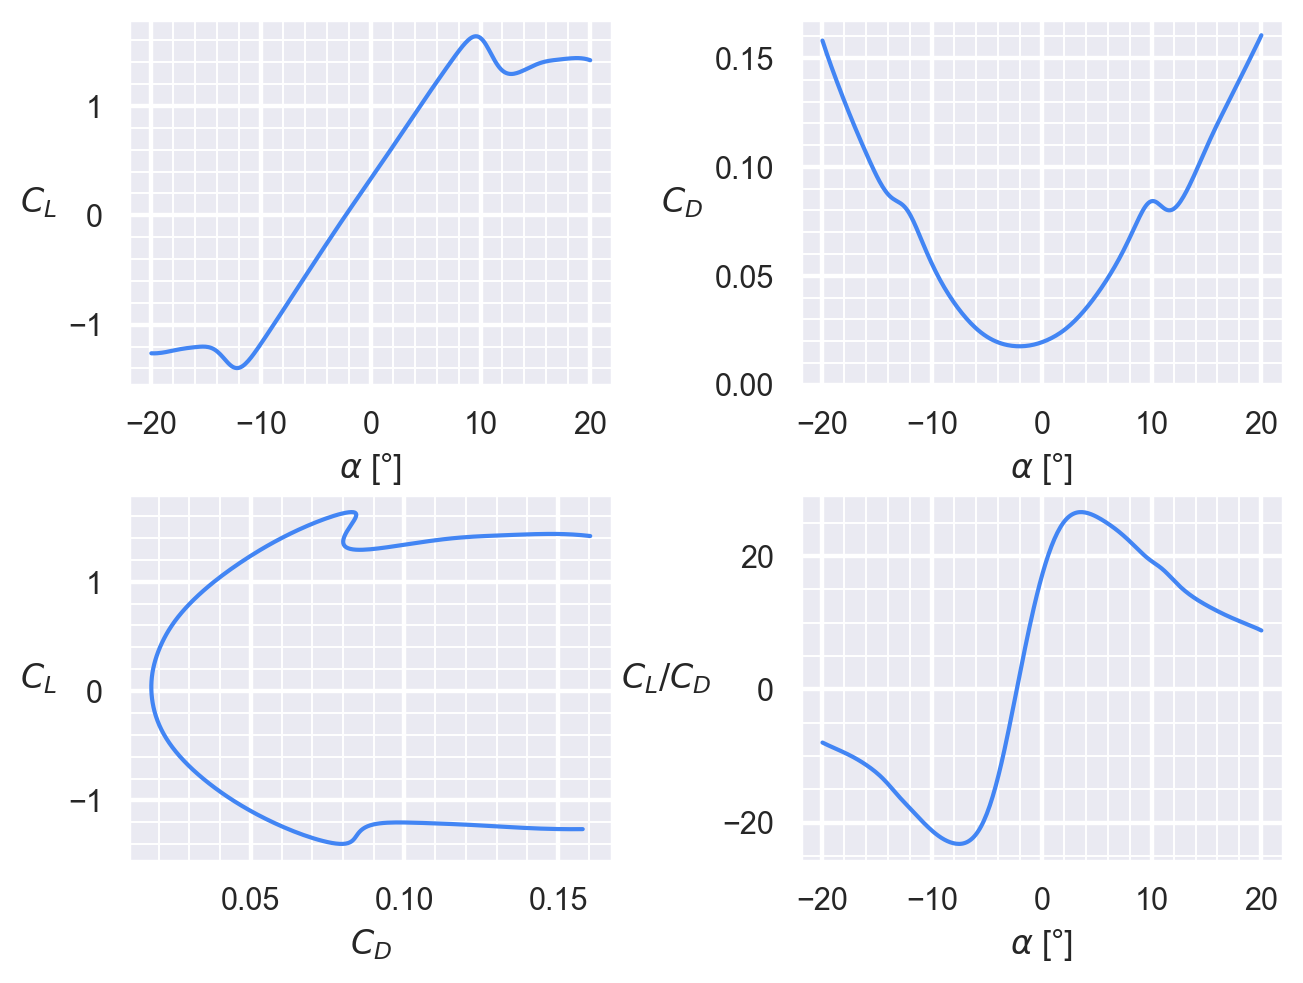

In [13]:
# Plotting
alpha = np.linspace(-20, 20, 300)

ps3_mach = 0.5  # [mach]
ps3_speed = atm.speed_of_sound() * ps3_mach

aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=ps3_speed,
        alpha=alpha,
        beta=0
    ),
).run()

fig, ax = plt.subplots(2, 2)

cl = aero["CL"]
lift_curve_slope = (cl[225]-cl[75])/(alpha[225]-alpha[75])
print("C_L_alpha, Lift curve slope:", lift_curve_slope)
print("Drag", aero["CD"][150])
print("Drag Force", aero["D_profile"][150])


plt.sca(ax[0, 0])
plt.plot(alpha, aero["CL"])
plt.xlabel(r"$\alpha$ [°]")
plt.ylabel(r"$C_L$")
p.set_ticks(5, 1, 0.5, 0.1)

plt.sca(ax[0, 1])
plt.plot(alpha, aero["CD"])
plt.xlabel(r"$\alpha$ [°]")
plt.ylabel(r"$C_D$")
p.set_ticks(5, 1, 0.05, 0.01)
plt.ylim(bottom=0)

plt.sca(ax[1, 0])
plt.plot(aero["CD"], aero["CL"])
plt.xlabel(r"$C_D$")
plt.ylabel(r"$C_L$")
p.set_ticks(5, 1, 0.5, 0.1)

plt.sca(ax[1, 1])
plt.plot(alpha, aero["CL"] / aero["CD"])
plt.xlabel(r"$\alpha$ [°]")
plt.ylabel(r"$C_L/C_D$")
p.set_ticks(5, 1, 10, 2)

p.show_plot()

Results at takeoff altitude: 2438.4 m
Speed of sound: 331.10956996701873 m/s
Density: 0.961038142353875 kg/m^3
Maximum CL: 2.1483513874024784
CL at optimal angle of attack: 0.4988269127973978


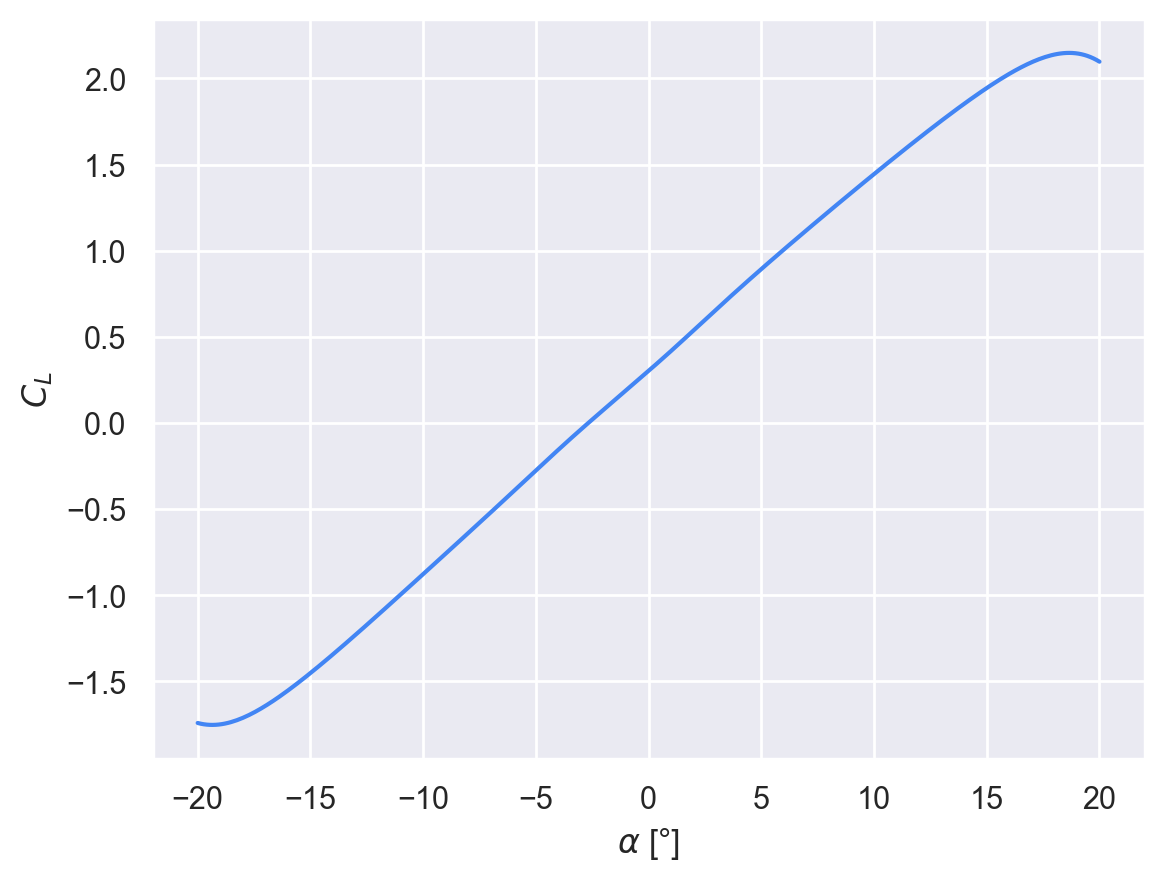

In [ ]:
# Calculate CL at a takeoff altitude
takeoff_altitude = 2438.4  # [m] - example altitude
takeoff_atm = asb.atmosphere.Atmosphere(takeoff_altitude)
takeoff_speed = 77.16 # m/s

# Calculate aerodynamics at new altitude
takeoff_aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=takeoff_speed,
        alpha=alpha,
        beta=0
    ),
).run()

# Print results
print("Results at takeoff altitude:", takeoff_altitude, "m")
print("Speed of sound:", takeoff_atm.speed_of_sound(), "m/s")
print("Density:", takeoff_atm.density(), "kg/m^3")
print("Maximum CL:", np.max(takeoff_aero["CL"]))
print("CL at optimal angle of attack:", takeoff_aero["CL"][np.argmax(takeoff_aero["CL"] / takeoff_aero["CD"])])

# Plot alpha x CL
plt.clf()
plt.plot(alpha, takeoff_aero["CL"])
plt.xlabel(r"$\alpha$ [°]")
plt.ylabel(r"$C_L$")
p.set_ticks(5, 1, 0.5, 0.1)
plt.show()

In [35]:
# Filter alpha values greater than 0
cl_takeoff = 2 * weight / (takeoff_atm.density() * sol(main_wing).area() * takeoff_speed**2)
cl_max = takeoff_aero["CL"][225]
cl_delta = cl_takeoff - cl_max

# Find the index of cl_max
cl_max_index = np.argmax(takeoff_aero["CL"])
alpha_at_cl_max = takeoff_aero["alpha"][cl_max_index]

print("Alpha at CL max:", alpha_at_cl_max)
print("CL Max (constrained):", cl_max)
print("CL Takeoff:", cl_takeoff)
print("CL Delta:", cl_delta)

KeyError: 'alpha'

In [36]:
wing_area = main_wing.area()

c_prime_ratio = 1.5 # Typical ratio of c_prime to c_root according to the internet

# Name of Flap Type, [delta_CL, complexity]
flap_types = {"Plain and Split": [0.9, 1],
              "Slatted": [1.3, 1.2],
              "Fowler": [1.3 * c_prime_ratio, 2],
              "Double Slotted": [1.6 * c_prime_ratio, 3],
              "Triple Slotted": [1.9 * c_prime_ratio, 4]
              }

# Name of Leading Edge Flap Type, [delta_CL, complexity]
leading_flap_types = {"Fixed Slot": [0.2, 1],
                      "Leading Edge Flap": [0.3, 1],
                      "Kruger Flap": [0.3, 1.5],
                      "Slat": [0.4 * c_prime_ratio, 2]
                      }

def flap_opti_function(rear_flap_types, lead_flap_types):
    size_weight = 1
    complexity_weight = .25
    combo = []
    eval = []
    s_flap_comp = []
    for rear_flap_type in rear_flap_types:
        for leading_flap_type in lead_flap_types:
            delta_CL = flap_types[rear_flap_type][0] + lead_flap_types[leading_flap_type][0]
            s_flapped_rear = (cl_delta * .8) / (0.9 * rear_flap_types[rear_flap_type][0] * np.cos(np.deg2rad(20)))
            s_flapped_front = (cl_delta * .2) / (0.9 * lead_flap_types[leading_flap_type][0] * np.cos(np.deg2rad(20)))
            complexity = rear_flap_types[rear_flap_type][1] + lead_flap_types[leading_flap_type][1]
            s_flap_comp.append([s_flapped_rear, s_flapped_front, complexity])
            combo.append(rear_flap_type + " + " + leading_flap_type)
            eval.append((size_weight * (s_flapped_rear + s_flapped_front)) + (complexity_weight * complexity))
    return combo, eval, s_flap_comp

In [37]:
# Run optimization function and print results
combo, eval, s_flap_comp = flap_opti_function(flap_types, leading_flap_types)
for c, e in zip(combo, eval):
    print(f"{c}: {round(e, 2)}")
best_index = eval.index(min(eval))
print(f"\nBest combo: {combo[best_index]}")
print("S_flapped of front flap:", round(s_flap_comp[best_index][1],3))
print("S_flapped of rear flap:", round(s_flap_comp[best_index][0],3))
print("Complexity of best combo:", s_flap_comp[best_index][2])


Plain and Split + Fixed Slot: 2.56
Plain and Split + Leading Edge Flap: 2.2
Plain and Split + Kruger Flap: 2.32
Plain and Split + Slat: 2.09
Slatted + Fixed Slot: 2.32
Slatted + Leading Edge Flap: 1.95
Slatted + Kruger Flap: 2.08
Slatted + Slat: 1.84
Fowler + Fixed Slot: 2.29
Fowler + Leading Edge Flap: 1.93
Fowler + Kruger Flap: 2.05
Fowler + Slat: 1.81
Double Slotted + Fixed Slot: 2.46
Double Slotted + Leading Edge Flap: 2.09
Double Slotted + Kruger Flap: 2.22
Double Slotted + Slat: 1.98
Triple Slotted + Fixed Slot: 2.65
Triple Slotted + Leading Edge Flap: 2.29
Triple Slotted + Kruger Flap: 2.41
Triple Slotted + Slat: 2.17

Best combo: Fowler + Slat
S_flapped of front flap: 0.364
S_flapped of rear flap: 0.448
Complexity of best combo: 4
